# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [133]:
# Import necessary libraries; additional libraries can be added as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Note: Using sklearn version 1.6.1

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [134]:
# Load the general demographics dataset into a DataFrame
demographics_data = pd.read_csv('Udacity_AZDIAS_Subset.csv', delimiter=';')

# Load the feature summary file into another DataFrame
feature_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')


In [135]:

# Examine the structure of the demographics dataset
# Print the number of rows and columns, and display the first few rows
print('Dimensions of the demographics dataset:', demographics_data.shape)
demographics_data.head()

Dimensions of the demographics dataset: (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [136]:
demographics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [137]:
# Examine the structure of the feature summary dataset
print('Dimensions of the feature summary dataset:', feature_summary.shape)
feature_summary.head()

Dimensions of the feature summary dataset: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [138]:
feature_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feature_summary`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [139]:

# Calculate the total number of naturally missing values before conversion
total_natural_nans = demographics_data.isna().sum().sum()
total_natural_nans

4896838

In [140]:

# Convert missing or unknown data values to NaNs based on the feature summary
for col, missing_indices in zip(feature_summary['attribute'], feature_summary['missing_or_unknown']):
    missing_values = missing_indices.strip('[]').split(',')
    missing_values = [int(val) if (val != 'X' and val != 'XX' and val != '') else val for val in missing_values]
    if missing_values != ['']:
        demographics_data[col] = demographics_data[col].replace(missing_values, np.nan)

In [141]:
total_nans_after_conversion = demographics_data.isna().sum().sum()
total_nans_after_conversion

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [142]:
# Assess the amount of missing data in each column of the dataset
missing_values_per_column = demographics_data.isna().sum()
missing_values_per_column

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

Text(0, 0.5, 'Number of columns')

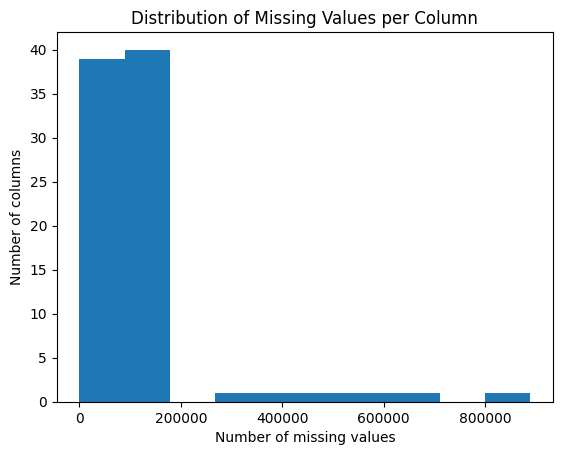

In [143]:
# Visualize the distribution of missing data across columns
plt.hist(missing_values_per_column)
plt.title('Distribution of Missing Values per Column')
plt.xlabel('Number of missing values')
plt.ylabel('Number of columns')


Text(0, 0.5, 'Number of columns')

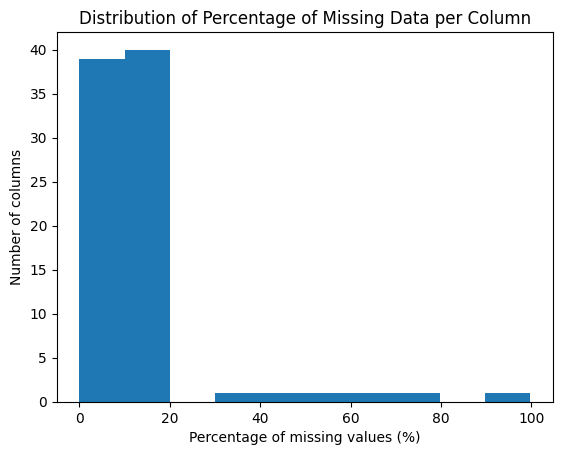

In [144]:
# Calculate the percentage of missing data in each column
missing_percentage_per_column = (demographics_data.isnull().sum() / len(demographics_data)) * 100
plt.hist(missing_percentage_per_column)
plt.title('Distribution of Percentage of Missing Data per Column')
plt.xlabel('Percentage of missing values (%)')
plt.ylabel('Number of columns')


In [145]:
# Display columns with more than 20% missing data
high_missing_percentage_columns = missing_percentage_per_column[missing_percentage_per_column > 20]
high_missing_percentage_columns

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

In [146]:
# Display columns with more than 200,000 missing values
high_missing_value_columns = missing_values_per_column[missing_values_per_column > 200000]
high_missing_value_columns


AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [147]:
# Remove columns with more than 20% missing data from the demographics dataset
demographics_data.drop(high_missing_percentage_columns.index, axis=1, inplace=True)

In [148]:

# Remove the same columns from the feature summary dataset for consistency
cleaned_feature_summary = feature_summary[~feature_summary.attribute.isin(high_missing_percentage_columns.index)]


#### Discussion 1.1.2: Assess Missing Data in Each Column

We noticed that most columns have between 0% and 20% of their values as NaN. However, certain columns exceed this threshold.

We have removed the columns with more than 20% NaN values, which are:
GEBURTSJAHR, TITEL_KZ, ALTER_HH, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [149]:

# Calculate the number of missing values in each row of the dataset
missing_values_per_row = demographics_data.isnull().sum(axis=1)

Text(0, 0.5, 'Number of rows')

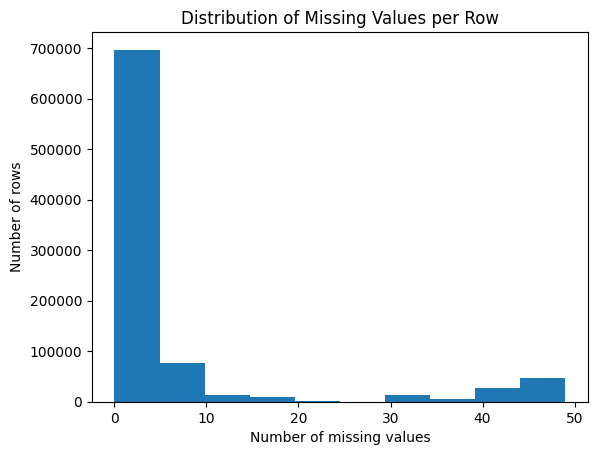

In [150]:
# Visualize the distribution of missing values per row
plt.hist(missing_values_per_row)
plt.title('Distribution of Missing Values per Row')
plt.xlabel('Number of missing values')
plt.ylabel('Number of rows')

In [151]:
# Split the dataset into two subsets based on a threshold of missing values per row
missing_value_threshold = 20
subset_high_missing = demographics_data[missing_values_per_row > missing_value_threshold]
subset_low_missing = demographics_data[missing_values_per_row <= missing_value_threshold]

In [152]:
# Compare the distribution of values for columns with few or no missing values between the two subsets
def compare_distributions(column_name, high_missing_subset, low_missing_subset, threshold_value):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    fig.set_figwidth(15)
    
    ax1.set_title(f'Rows with missing values above {threshold_value}')
    ax1.hist(high_missing_subset[column_name].dropna(), bins=20, edgecolor='black')
    
    ax2.set_title(f'Rows with missing values below {threshold_value}')
    ax2.hist(low_missing_subset[column_name].dropna(), bins=20, edgecolor='black')
    
    plt.show()

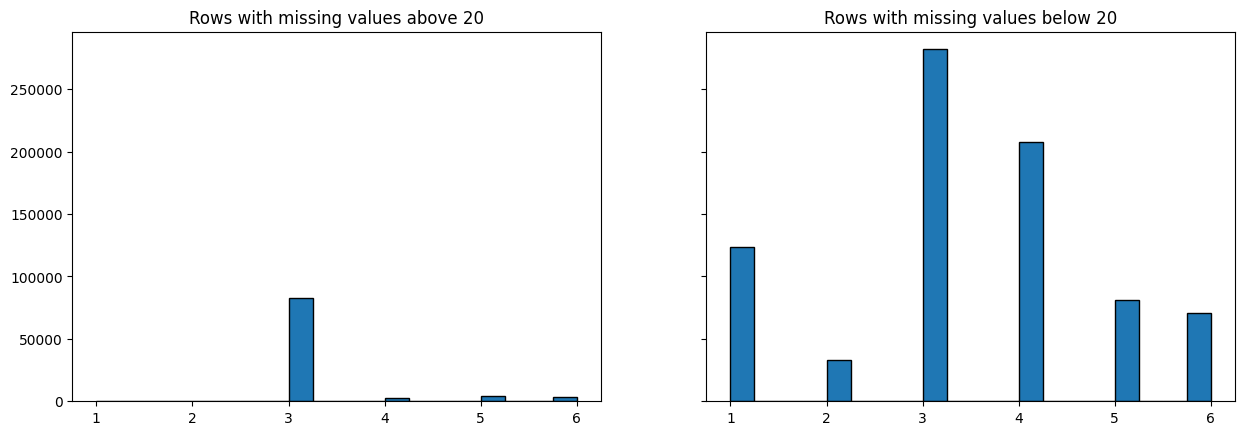

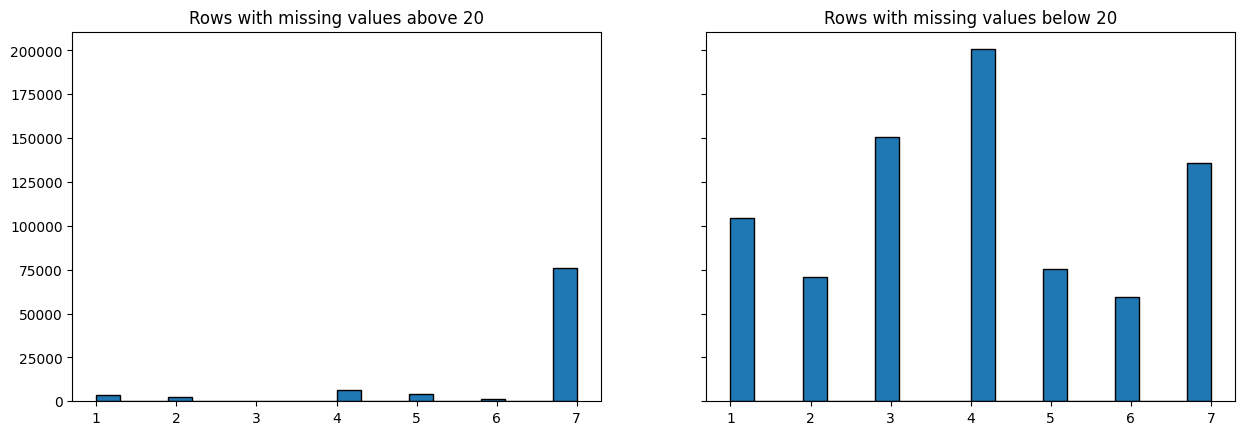

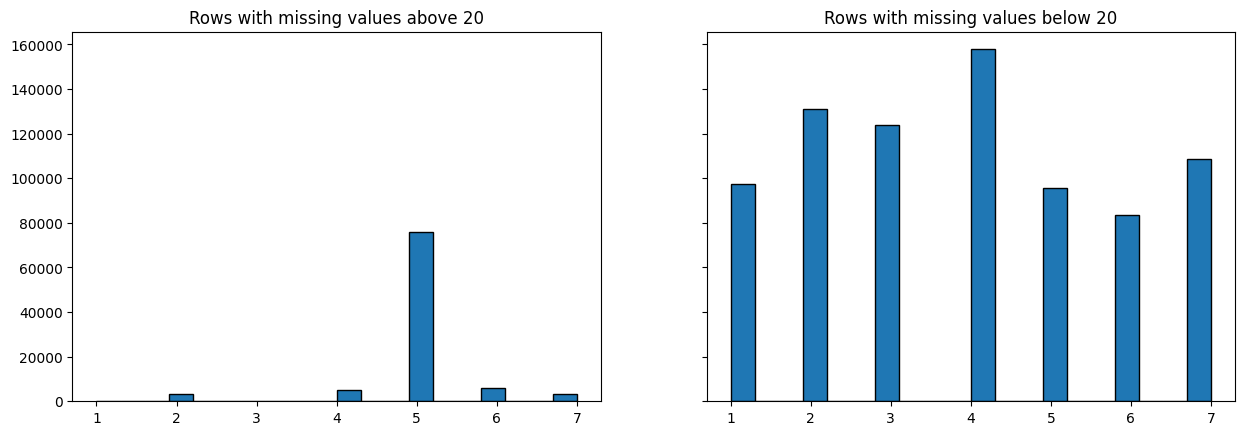

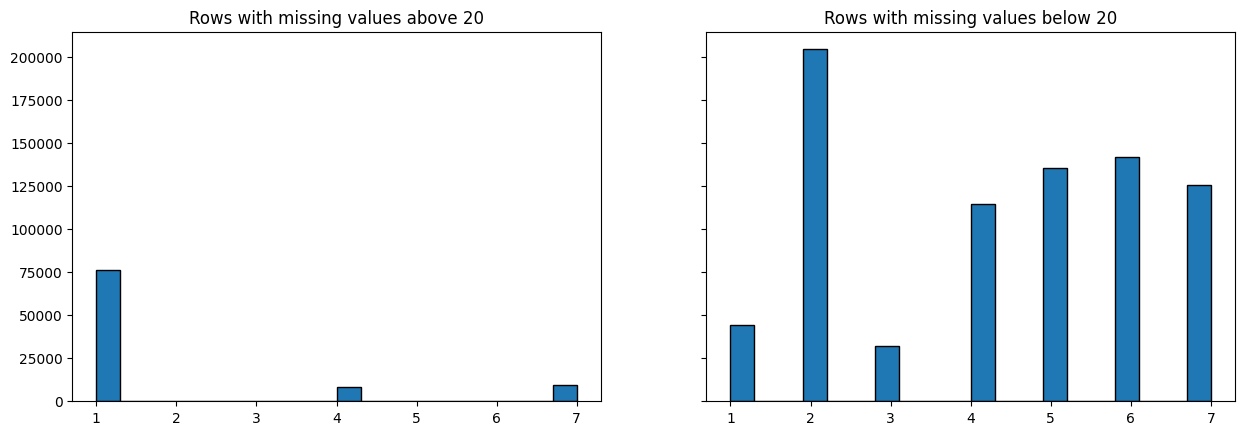

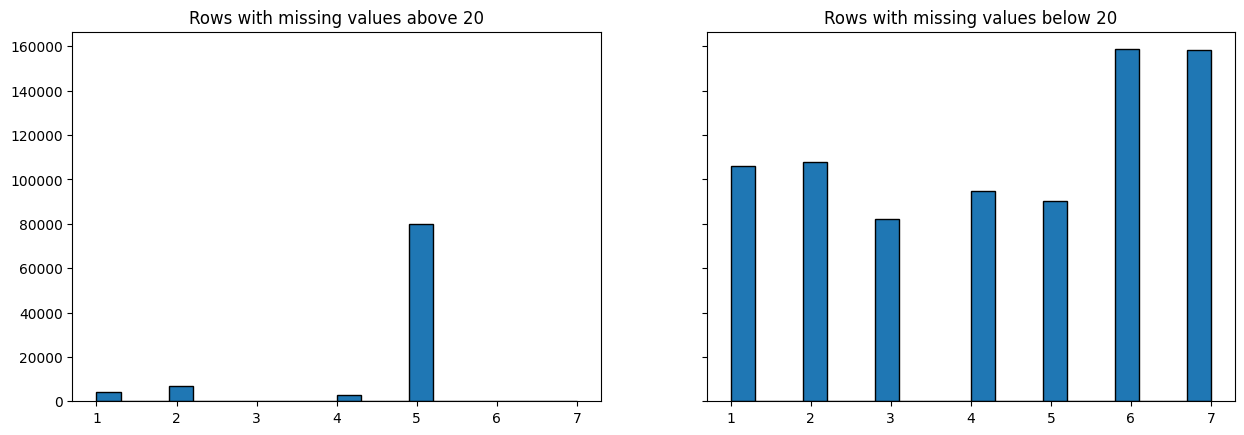

In [153]:
# Identify the 5 columns with the least missing values
columns_with_least_nulls = list(demographics_data.isna().sum().sort_values().index[:5])

# Compare distributions for these columns between subsets with high and low missing values
for col in columns_with_least_nulls:
    compare_distributions(col, subset_high_missing, subset_low_missing, missing_value_threshold)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data containing a large proportion of missing values seems to differ significantly from the data with minimal or no missing values. This difference is particularly noticeable when examining the first five columns, which have no missing data, in contrast to those with substantial gaps.

Given this distinction, it’s crucial to acknowledge that datasets with extensive missing values are distinct in nature and may need tailored approaches in our analysis to account for their unique characteristics.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [154]:

# Count the number of features for each data type in the cleaned feature summary
feature_type_counts = cleaned_feature_summary['type'].value_counts()
feature_type_counts


type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [155]:

# Extract categorical features from the cleaned feature summary
categorical_features = cleaned_feature_summary[cleaned_feature_summary.type == 'categorical'].attribute

# Calculate the number of unique values for each categorical feature in the low-missing subset
unique_values_per_cat_feature = subset_low_missing[categorical_features].nunique()

In [156]:
# Categorize categorical features into binary numeric, binary non-numeric, and multi-level
binary_numeric_features = []
binary_non_numeric_features = []
multi_level_features = []

for unique_count, feature in zip(unique_values_per_cat_feature, categorical_features):
    if unique_count != 2:
        multi_level_features.append(feature)
    else:
        feature_dtype = subset_low_missing[feature].dtype
        if np.issubdtype(feature_dtype, np.number):
            binary_numeric_features.append(feature)
        else:
            binary_non_numeric_features.append(feature)

In [157]:

# Print the categorized features
print('Numeric binary features:\n', binary_numeric_features)
print('\nNon-numeric binary features:\n', binary_non_numeric_features)
print('\nMulti-level features:\n', multi_level_features)
print('\nUnique values per categorical feature:\n', unique_values_per_cat_feature)


Numeric binary features:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']

Non-numeric binary features:
 ['OST_WEST_KZ']

Multi-level features:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Unique values per categorical feature:
 ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64


In [158]:

# Drop categorical features with more than 20 unique values
features_to_drop = unique_values_per_cat_feature[unique_values_per_cat_feature > 20].index
subset_low_missing.drop(features_to_drop, axis=1, inplace=True)

# Remove dropped features from the multi-level features list
for feature in features_to_drop:
    multi_level_features.remove(feature)

C:\Users\F\AppData\Local\Temp\ipykernel_38204\863349711.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_low_missing.drop(features_to_drop, axis=1, inplace=True)


In [159]:
# Re-encode categorical features for analysis

# 1) Re-encode non-numeric binary features
subset_low_missing['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)
subset_low_missing['OST_WEST_KZ'] = subset_low_missing['OST_WEST_KZ'].astype('int')

# 2) Re-encode multi-level categorical features using dummy variables
subset_low_missing = pd.get_dummies(data=subset_low_missing, columns=multi_level_features)

C:\Users\F\AppData\Local\Temp\ipykernel_38204\584403198.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  subset_low_missing['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace=True)
C:\Users\F\AppData\Local\Temp\ipykernel_38204\584403198.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subset_low

#### Discussion 1.2.1: Re-Encode Categorical Features

In the dataset, we identified only five binary features, one of which was non-numeric. However, the majority of the categorical features were multi-level. To handle this, I retained all numeric binary categorical features and re-encoded the non-numeric binary feature by mapping the category 'W' to 0 and 'O' to 1.

For the multi-level categorical features, I used dummy variable encoding. Additionally, I dropped any column with more than 20 categories to avoid creating an excessively large dataset after re-encoding. This was necessary because one of the columns in our dataset contained 44 unique categories, which would have significantly expanded the dataset if encoded.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#### PRAEGENDE_JUGENDJAHRE:

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
- 0: unknown
- 1: 40s - war years (Mainstream, E+W)
- 2: 40s - reconstruction years (Avantgarde, E+W)
- 3: 50s - economic miracle (Mainstream, E+W)
- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- 5: 60s - economic miracle (Mainstream, E+W)
- 6: 60s - generation 68 / student protestors (Avantgarde, W)
- 7: 60s - opponents to the building of the Wall (Avantgarde, E)
- 8: 70s - family orientation (Mainstream, E+W)
- 9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [160]:

# Engineer new features from "PRAEGENDE_JUGENDJAHRE"

# Define mainstream movements
mainstream_movements = [1, 3, 5, 8, 10, 12, 14]

# 1) Create a binary movement feature
subset_low_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = subset_low_missing['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x in mainstream_movements else 0)

# 2) Create a decade feature using a mapping
decade_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}

subset_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = subset_low_missing['PRAEGENDE_JUGENDJAHRE']
subset_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_mapping, inplace=True)


C:\Users\F\AppData\Local\Temp\ipykernel_38204\597097074.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  subset_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'].replace(decade_mapping, inplace=True)


#### CAMEO_INTL_2015:

German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [161]:
# Engineer new features from "CAMEO_INTL_2015"

# 1) Extract wealth information
subset_low_missing['WEALTH'] = subset_low_missing['CAMEO_INTL_2015']
subset_low_missing['WEALTH'] = subset_low_missing['WEALTH'].apply(lambda x: x if pd.isnull(x) else int(x[1]))

# 2) Extract life stage information
subset_low_missing['LIFE_STAGE'] = subset_low_missing['CAMEO_INTL_2015']
subset_low_missing['LIFE_STAGE'] = subset_low_missing['LIFE_STAGE'].apply(lambda x: x if pd.isnull(x) else int(x[0]))

#### Discussion 1.2.2: Engineer Mixed-Type Features

I've kept both of the mixed features, but we've dealt with each of them differently.

Firstly, with `PRAEGENDE_JUGENDJAHRE`, we create two new variables, one for the movement and the other for the decade.
We create the movement as two binary variables, '1' refers to the mainstream, and '0' refers to avantgarde.

Regarding the decade, we create it as an interval variable, we map each decade to a specific number.


Secondly, with `CAMEO_INTL_2015`, we break up the two-digit codes to their 'tens'-place and 'ones'-place digits into two new ordinal variables, tens place for the wealth and ones place for the life stage.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [162]:
# Drop mixed-type features to ensure the dataframe only contains relevant columns
mixed_type_features = cleaned_feature_summary[cleaned_feature_summary['type'] == 'mixed']['attribute'].values
subset_low_missing.drop(mixed_type_features, axis=1, inplace=True)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [163]:

def clean_data(demographics_df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Convert missing value codes into NaNs
    for attribute, missing_indices in zip(feature_summary['attribute'], feature_summary['missing_or_unknown']):
        missing_values = missing_indices.strip('[]').split(',')
        missing_values = [int(val) if (val != 'X' and val != 'XX' and val != '') else val for val in missing_values]
        if missing_values != ['']:
            demographics_df.loc[:, attribute] = demographics_df[attribute].replace(missing_values, np.nan)

    # Remove selected columns and rows
    columns_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    demographics_df.drop(columns_to_drop, axis=1, inplace=True)
    cleaned_feature_summary = feature_summary[~feature_summary.attribute.isin(columns_to_drop)]
    
    # Split data into subsets based on the number of missing values per row
    missing_values_per_row = demographics_df.isnull().sum(axis=1)
    threshold = 20
    subset_high_missing = demographics_df[missing_values_per_row > threshold]
    subset_low_missing = demographics_df[missing_values_per_row <= threshold]
    
    # Select, re-encode, and engineer column values
    categorical_features = cleaned_feature_summary[cleaned_feature_summary.type == 'categorical'].attribute
    unique_values_per_cat_feature = subset_low_missing[categorical_features].nunique()
    
    binary_numeric_features = []
    binary_non_numeric_features = []
    multi_level_features = []
    for unique_count, feature in zip(unique_values_per_cat_feature, categorical_features):
        if unique_count != 2:
            multi_level_features.append(feature)
        else:
            feature_dtype = subset_low_missing[feature].dtype
            if np.issubdtype(feature_dtype, np.number):
                binary_numeric_features.append(feature)
            else:
                binary_non_numeric_features.append(feature)
                
    # Drop features with more than 20 unique values
    features_to_drop = unique_values_per_cat_feature[unique_values_per_cat_feature > 20].index
    subset_low_missing.drop(features_to_drop, axis=1, inplace=True)
    for feature in features_to_drop:
        multi_level_features.remove(feature)
        
    # Re-encode binary categorical features
    subset_low_missing.loc[:, 'OST_WEST_KZ'] = subset_low_missing['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
    subset_low_missing.loc[:, 'OST_WEST_KZ'] = subset_low_missing['OST_WEST_KZ'].astype('int')

    # Re-encode multi-level categorical features
    subset_low_missing = pd.get_dummies(data=subset_low_missing, columns=multi_level_features)
    
    # Engineer mixed-type features
    mainstream_movements = [1, 3, 5, 8, 10, 12, 14]
    subset_low_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = subset_low_missing['PRAEGENDE_JUGENDJAHRE'].apply(
        lambda x: 1 if x in mainstream_movements else 0)

    decade_mapping = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
    subset_low_missing['PRAEGENDE_JUGENDJAHRE_DECADE'] = subset_low_missing['PRAEGENDE_JUGENDJAHRE'].replace(decade_mapping)
    
    subset_low_missing['WEALTH'] = subset_low_missing['CAMEO_INTL_2015'].apply(lambda x: x if pd.isnull(x) else int(x[1]))
    subset_low_missing['LIFE_STAGE'] = subset_low_missing['CAMEO_INTL_2015'].apply(lambda x: x if pd.isnull(x) else int(x[0]))
    
    # Drop mixed-type features
    mixed_features = cleaned_feature_summary[cleaned_feature_summary['type'] == 'mixed']['attribute'].values
    subset_low_missing.drop(mixed_features, axis=1, inplace=True)
    
    # Fill NaN values with the most frequent value (mode) of each column
    imputer = SimpleImputer(strategy='most_frequent')
    imputed_values = imputer.fit_transform(subset_low_missing)
    subset_low_missing = pd.DataFrame(imputed_values, columns=subset_low_missing.columns)
    
    # Return the cleaned dataframe
    return subset_low_missing


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [164]:

# Check the number of observations and NaN values in the dataset
print('Number of observations in the dataset:', subset_low_missing.shape[0])
print('NaN values in the dataset:', subset_low_missing.isna().sum().sum())

Number of observations in the dataset: 797426
NaN values in the dataset: 723421


In [165]:

# Fill NaNs using the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
imputed_values = imputer.fit_transform(subset_low_missing)
subset_low_missing = pd.DataFrame(imputed_values, columns=subset_low_missing.columns)

In [166]:

# Verify that all NaNs have been filled
print('NaN values in the dataset after filling NaNs:', subset_low_missing.isna().sum().sum())

NaN values in the dataset after filling NaNs: 0


In [167]:
# Apply feature scaling to the general population demographics data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(subset_low_missing)
scaled_features = pd.DataFrame(scaled_features, columns=subset_low_missing.columns)

### Discussion 2.1: Apply Feature Scaling

To address the missing values in the dataset, I used the Imputer instance to fill NaN values with the mode of each respective feature. It was surprising to see the high volume of missing values relative to the total number of observations.

Additionally, I standardized all features by scaling them to a mean of 0 and a standard deviation of 1 using the StandardScaler instance. This ensures that the data is normalized and ready for further analysis or modeling.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [168]:

# Apply PCA to the scaled features

# Set the number of components to half the number of features
n_components = scaled_features.shape[1] // 2
pca = PCA(n_components=n_components)
pca = pca.fit(scaled_features)
original_columns = scaled_features.columns.tolist()

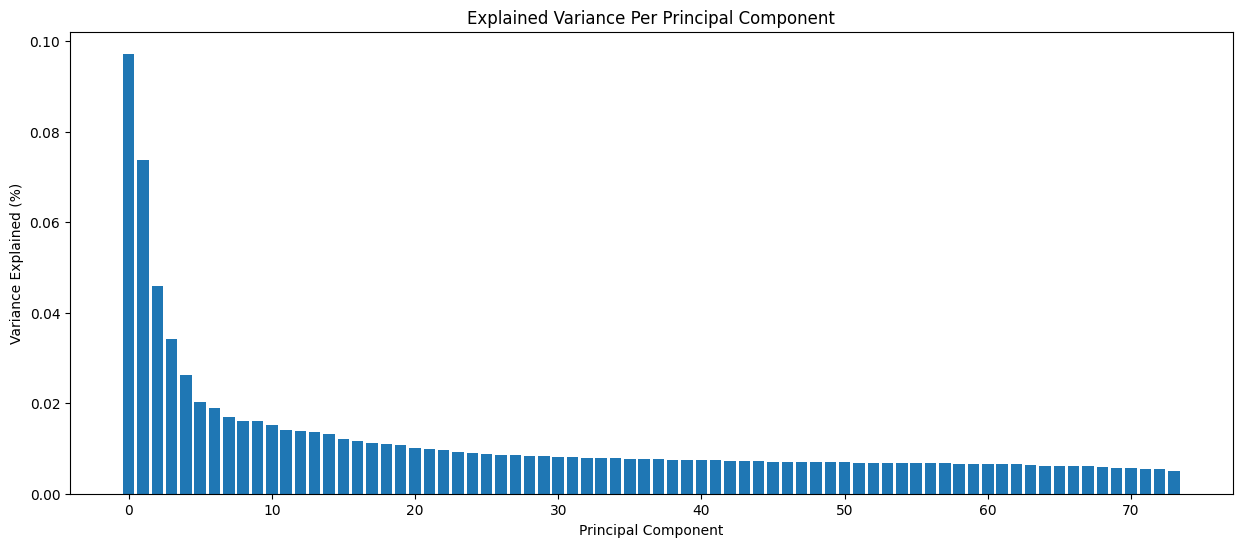

In [169]:
# Investigate the variance accounted for by each principal component

# Plot the explained variance per principal component
components = np.arange(n_components)
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(15, 6))
plt.bar(components, explained_variance)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained (%)")
plt.title("Explained Variance Per Principal Component");


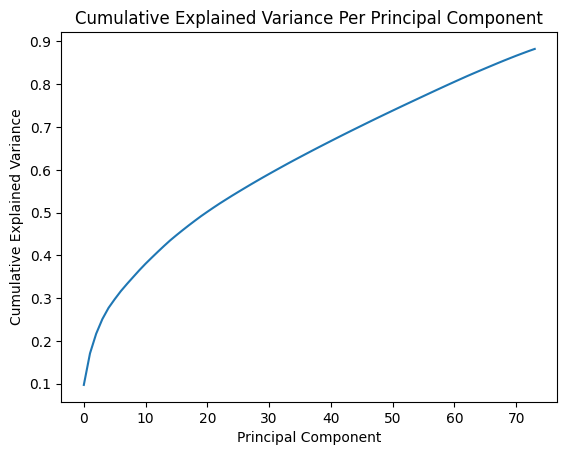

In [170]:
# Plot the cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)
plt.plot(components, cumulative_variance)
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance Per Principal Component");

In [171]:
print('Cumulative Explained Variance:', pca.explained_variance_ratio_.sum())

Cumulative Explained Variance: 0.8826071202185153


In [172]:

# Re-apply PCA to the data while selecting for the number of components to retain

# Use the same number of components as before (78) and transform the data
data_pca = pca.transform(scaled_features)

### Discussion 2.2: Perform Dimensionality Reduction

We've retained 78 components, which is half the number of features that we have.
And from that, we've got cumulative variance explained the original data about 88%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [173]:
# Define a function to map component weights to feature names
def map_component_weights(df, pca, component):
    """
    Input:
        df - DataFrame
        pca - Fitted PCA instance
        component - Index of the component
        
    Return:
        DataFrame: Mapped features to their weights in the component
    """
    component_weights = pd.DataFrame(pca.components_, columns=list(df.columns)).iloc[component]
    component_weights.sort_values(ascending=False, inplace=True)
    
    return component_weights

# Define a function to plot component weights
def plot_component_weights(df, pca, component, num_features_to_plot):
    """
    Input:
        df - DataFrame
        pca - Fitted PCA instance
        component - Index of the component
        num_features_to_plot - Number of top and bottom features to plot
    """
    component_weights = map_component_weights(df, pca, component)
    component_weights = pd.concat([component_weights.head(num_features_to_plot), component_weights.tail(num_features_to_plot)])
    
    component_weights.plot(kind='bar')
    plt.title(f'Component {component + 1}')
    plt.ylabel('Weight')
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()
    
    return component_weights


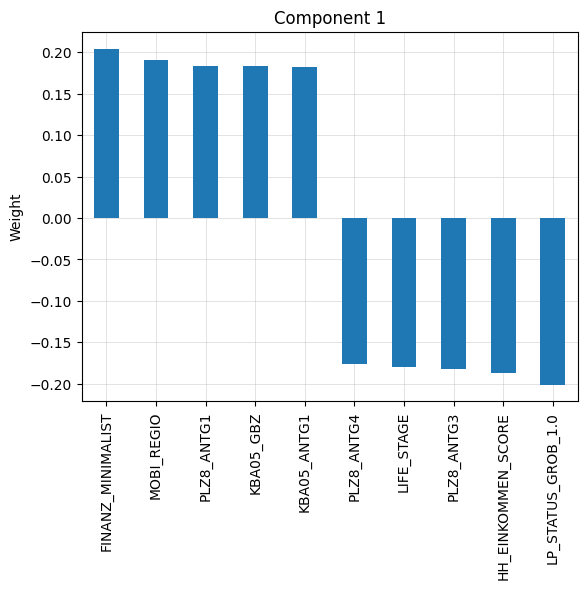

FINANZ_MINIMALIST     0.204204
MOBI_REGIO            0.189903
PLZ8_ANTG1            0.183095
KBA05_GBZ             0.182832
KBA05_ANTG1           0.182370
PLZ8_ANTG4           -0.176137
LIFE_STAGE           -0.180093
PLZ8_ANTG3           -0.182365
HH_EINKOMMEN_SCORE   -0.186773
LP_STATUS_GROB_1.0   -0.200798
Name: 0, dtype: float64

In [174]:
# Map weights for the first principal component to corresponding feature names
# and print the linked values, sorted by weight
component_weights = plot_component_weights(scaled_features, pca, 0, 5)
component_weights


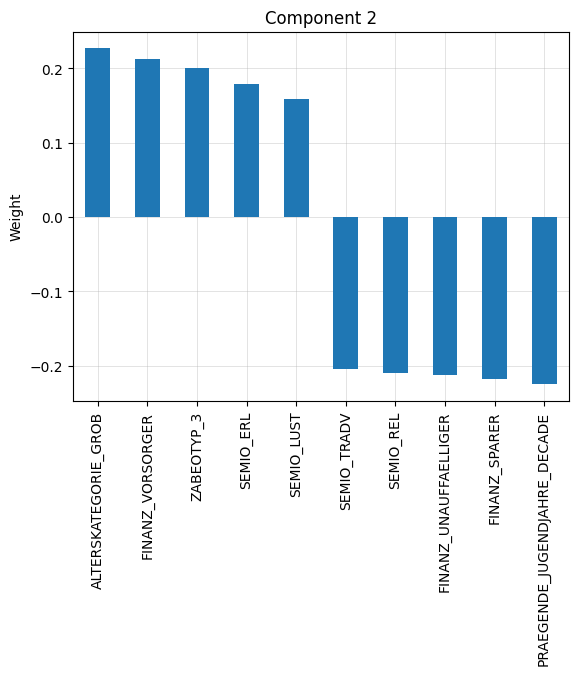

ALTERSKATEGORIE_GROB            0.226817
FINANZ_VORSORGER                0.212739
ZABEOTYP_3                      0.200337
SEMIO_ERL                       0.178362
SEMIO_LUST                      0.158829
SEMIO_TRADV                    -0.203539
SEMIO_REL                      -0.210109
FINANZ_UNAUFFAELLIGER          -0.211841
FINANZ_SPARER                  -0.217948
PRAEGENDE_JUGENDJAHRE_DECADE   -0.224823
Name: 1, dtype: float64

In [175]:
# Map weights for the second principal component to corresponding feature names
# and print the linked values, sorted by weight
component_weights = plot_component_weights(scaled_features, pca, 1, 5)
component_weights

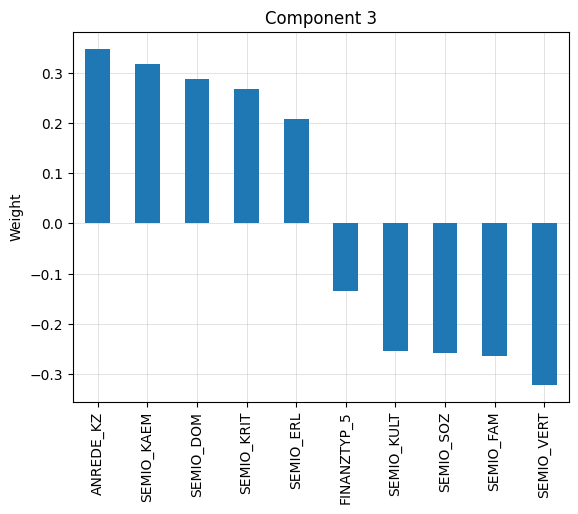

ANREDE_KZ      0.347977
SEMIO_KAEM     0.318409
SEMIO_DOM      0.288083
SEMIO_KRIT     0.268523
SEMIO_ERL      0.208220
FINANZTYP_5   -0.134453
SEMIO_KULT    -0.253531
SEMIO_SOZ     -0.258214
SEMIO_FAM     -0.262867
SEMIO_VERT    -0.321031
Name: 2, dtype: float64

In [176]:
component_weights = plot_component_weights(scaled_features, pca, 2, 5)
component_weights

- You can get all features weights by using ``map_component_weights`` function.

### Discussion 2.3: Interpret Principal Components

1. First Principal Component

  - Negative weights
    - LP_STATUS_GROB_1.0 (Social status: low-income earners)
    - HH_EINKOMMEN_SCORE (Estimated household net income)
    - PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region)
  - Positive weights
    - FINANZ_MINIMALIST (Financial typology: low financial interest)
    - MOBI_REGIO (Movement patterns)
    - PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)


2. Second Principal Component

  - Positive weights
    - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
    - FINANZ_VORSORGER (Financial typology: be prepared)
    - ZABEOTYP_3 (Energy consumption typology: fair supplied)
  - Negative weights
    - PRAEGENDE_JUGENDJAHRE_DECADE (Generation)
    - FINANZ_SPARER (Financial typology: money-saver)
    - FINANZ_UNAUFFAELLIGER (Financial typology: inconspicuous)

3. Third Principal Component

  - Negative weights
    - SEMIO_VERT (Personality typology: dreamful)
    - SEMIO_FAM (Personality typology: family-minded)
    - SEMIO_SOZ (Personality typology: socially-minded)
  - Positive weights
    - ANREDE_KZ (Gender)
    - SEMIO_KAEM (Personality typology: combative attitude)
    - SEMIO_DOM (Personality typology: dominant-minded)
    
    
We can observe that the first component is about income and number of family houses. Also, we suggest that the second component was about financial typologies and age. And for the third component, it tells more about personality typologies.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [177]:
# Perform K-Means clustering over a range of cluster counts
from sklearn.cluster import KMeans

scores = []
cluster_counts = list(range(2, 21, 2))

# Iterate over different cluster counts
for count in cluster_counts:
    # Run K-Means clustering on the PCA-transformed data
    kmeans = KMeans(n_clusters=count)
    kmeans.fit(data_pca)
    # Compute the average within-cluster distances (SSE)
    score = np.abs(kmeans.score(data_pca))
    scores.append(score)

Text(0.5, 1.0, 'K vs SSE')

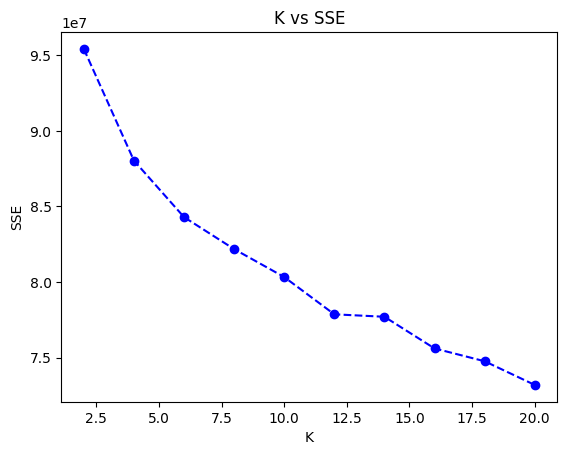

In [178]:

# Plot the relationship between the number of clusters and SSE
plt.plot(cluster_counts, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title("K vs SSE")

In [179]:

# Re-fit the K-Means model with the selected number of clusters (8)
# and obtain cluster predictions for the general population demographics data

kmeans = KMeans(n_clusters=8)
kmeans = kmeans.fit(data_pca)
general_predictions = kmeans.predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

I will use 8 as the number of clusters. I believe it's where the elbow at.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [180]:
# Load the customer demographics data
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [181]:

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data

try:
    customers_cleaned = clean_data(customers)
except Exception as e:
    print(f"An error occurred: {e}")

C:\Users\F\AppData\Local\Temp\ipykernel_38204\2879073735.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2. nan nan ...  2.  3.  3.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  demographics_df.loc[:, attribute] = demographics_df[attribute].replace(missing_values, np.nan)
C:\Users\F\AppData\Local\Temp\ipykernel_38204\2879073735.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[4. 4. 4. ... 4. 3. 2.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  demographics_df.loc[:, attribute] = demographics_df[attribute].replace(missing_values, np.nan)
C:\Users\F\AppData\Local\Temp\ipykernel_38204\2879073735.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[  nan   nan   nan ... 1944.  

In [182]:
print('NaN values in the dataset after filling NaNs:', customers_cleaned.isna().sum().sum())

NaN values in the dataset after filling NaNs: 0


In [183]:
# Identify columns in the general population data that are missing in the customer data
missing_columns = set(scaled_features.columns) - set(customers_cleaned.columns)
missing_columns

{'GEBAEUDETYP_5.0'}

In [184]:

# Add missing columns to the customer data with default values (e.g., 0)
for col in missing_columns:
    customers_cleaned[col] = 0

In [185]:

# Reorder the columns in customers_cleaned to match the original columns used during scaling
customers_cleaned = customers_cleaned[original_columns]

try:
    # Scale the cleaned customer data using the pre-fitted scaler
    customers_scaled = scaler.transform(customers_cleaned)
    customers_scaled = pd.DataFrame(customers_scaled, columns=customers_cleaned.columns)
    print("Scaling successful. Shape of scaled data:", customers_scaled.shape)
    
    # Apply PCA transformation to the scaled customer data using the pre-fitted PCA
    customers_pca = pca.transform(customers_scaled)
    print("PCA transformation successful. Shape of PCA data:", customers_pca.shape)
    
    # Predict cluster labels for the customer data using the pre-fitted KMeans model
    customers_preds = kmeans.predict(customers_pca)
    print("KMeans prediction successful. Predictions:", customers_preds)
    
except Exception as e:
    print(f"An error occurred: {e}")


Scaling successful. Shape of scaled data: (141640, 148)
PCA transformation successful. Shape of PCA data: (141640, 74)
KMeans prediction successful. Predictions: [1 1 5 ... 1 6 5]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

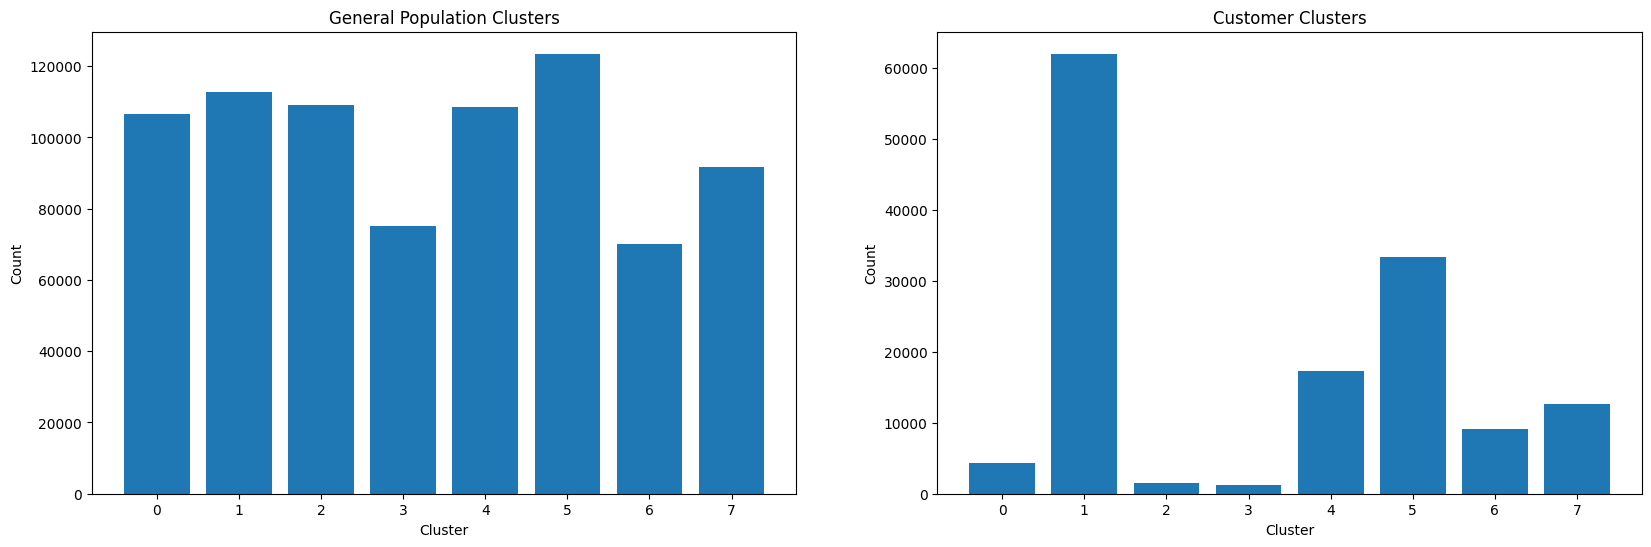

In [186]:

# Compare the proportion of data in each cluster for the customer data to the general population

# Create subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot general population clusters
unique_general, counts_general = np.unique(general_predictions, return_counts=True)
ax1.bar(unique_general, counts_general)
ax1.set_title('General Population Clusters')
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Count')

# Plot customer clusters
unique_customers, counts_customers = np.unique(customers_preds, return_counts=True)
ax2.bar(unique_customers, counts_customers)
ax2.set_title('Customer Clusters')
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Count')

plt.show()

In [ ]:



# Analyze the overrepresented cluster in the customer data (e.g., Cluster 1)

# Extract the cluster center for Cluster 1
cluster_center_1 = kmeans.cluster_centers_[1].reshape(1, -1)

# Apply inverse PCA transformation to the cluster center
centroid_pca_1 = pca.inverse_transform(cluster_center_1)

# Apply inverse scaling transformation to the PCA-transformed centroid
centroid_1 = scaler.inverse_transform(centroid_pca_1)

# Flatten the centroid array and create a Series for interpretation
centroid_1_flat = centroid_1.flatten()
overrepresented_cluster = pd.Series(data=centroid_1_flat, index=customers_cleaned.columns)
print("Characteristics of overrepresented cluster (Cluster 3):")
print(overrepresented_cluster.to_string())


Characteristics of overrepresented cluster (Cluster 4):
ALTERSKATEGORIE_GROB              3.251325e+00
ANREDE_KZ                         1.482020e+00
FINANZ_MINIMALIST                 4.536437e+00
FINANZ_SPARER                     1.757024e+00
FINANZ_VORSORGER                  4.077510e+00
FINANZ_ANLEGER                    1.927131e+00
FINANZ_UNAUFFAELLIGER             2.244890e+00
FINANZ_HAUSBAUER                  2.024380e+00
GREEN_AVANTGARDE                  9.720986e-01
HEALTH_TYP                        2.120836e+00
RETOURTYP_BK_S                    3.611431e+00
SEMIO_SOZ                         4.124641e+00
SEMIO_FAM                         3.592908e+00
SEMIO_REL                         3.180635e+00
SEMIO_MAT                         3.288955e+00
SEMIO_VERT                        4.740195e+00
SEMIO_LUST                        5.079170e+00
SEMIO_ERL                         5.016085e+00
SEMIO_KULT                        3.681440e+00
SEMIO_RAT                         3.284914e+00
SEMI

In [190]:

# Analyze the underrepresented cluster in the customer data (e.g., Cluster 3)

# Extract the cluster center for Cluster 3
cluster_center_3 = kmeans.cluster_centers_[3].reshape(1, -1)

# Apply inverse PCA transformation to the cluster center
centroid_pca_3 = pca.inverse_transform(cluster_center_3)

# Apply inverse scaling transformation to the PCA-transformed centroid
centroid_3 = scaler.inverse_transform(centroid_pca_3)

# Flatten the centroid array and create a Series for interpretation
centroid_3_flat = centroid_3.flatten()
underrepresented_cluster = pd.Series(data=centroid_3_flat, index=customers_cleaned.columns)
print("Characteristics of underrepresented cluster (Cluster 3):")
print(underrepresented_cluster.to_string())


Characteristics of underrepresented cluster (Cluster 3):
ALTERSKATEGORIE_GROB                 1.881365
ANREDE_KZ                            0.958280
FINANZ_MINIMALIST                    1.929564
FINANZ_SPARER                        4.420092
FINANZ_VORSORGER                     1.957182
FINANZ_ANLEGER                       3.579507
FINANZ_UNAUFFAELLIGER                3.878613
FINANZ_HAUSBAUER                     3.525452
GREEN_AVANTGARDE                     0.110032
HEALTH_TYP                           2.324936
RETOURTYP_BK_S                       2.563089
SEMIO_SOZ                            6.544368
SEMIO_FAM                            6.725650
SEMIO_REL                            6.185292
SEMIO_MAT                            5.152084
SEMIO_VERT                           6.103283
SEMIO_LUST                           2.991309
SEMIO_ERL                            2.242038
SEMIO_KULT                           6.823536
SEMIO_RAT                            4.052032
SEMIO_KRIT             

### Discussion 3.3: Compare Customer Data to Demographics Data

From the analysis above, we can say that 

Cluster 9 is **overrepresented** in the customers data compared to general population data, 
we can describe some segments of the population that are **relatively popular** with the mail-order company:

- People with age older than 60 years old is higher (ALTERSKATEGORIE_GROB =  3.25132)
- Females (ANREDE_KZ =  1.482020)
- People who are socially-minded (average affinity) (SEMIO_SOZ =  4.124641) 


Cluster 8 is **underrepresented** in the customers data compared to general population data, 
we can illustrate some segments of the population that are **relatively unpopular** with the company:

- People with age of 30 - 45 years old is lower (ALTERSKATEGORIE_GROB = 1.881365)
- Females (ANREDE_KZ = 0.958280)
- People who are socially-minded (high affinity) (SEMIO_SOZ = 6.544368) 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.